The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of plain_train_net failed: Traceback (most recent call last):
  File "/root/miniconda3/envs/detectron/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/root/miniconda3/envs/detectron/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/root/miniconda3/envs/detectron/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/root/miniconda3/envs/detectron/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/root/miniconda3/envs/detectron/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/root/miniconda3/envs/detectron/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 266, in upd

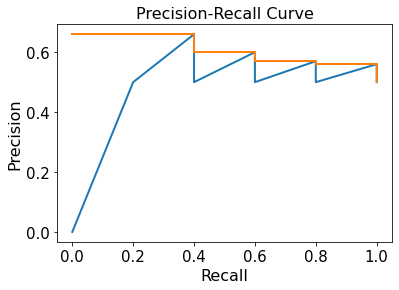

In [13]:
import shutil, os
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('ybpres.mplstyle')
plt.figure()
p = [0,.5,.66,.5,.6,.5,.57,.5,.56,.5]
p2 = [np.max(p[i:]) for i in range(len(p))]
r = [0,.2,.4,.4,.6,.6,.8,.8,1,1]
plt.plot(r,p)
plt.plot(r,p2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
from PIL import Image


In [14]:
import detectron2
from detectron2.data import DatasetCatalog,MetadataCatalog
from plain_train_net import grab_train,grab_valid
from detectron2.utils.visualizer import Visualizer
import cv2
from PIL import Image

try:
    DatasetCatalog.register("rpd_valid", grab_valid)
except:
    print('Already registered.')
    #do nothing
try:
    DatasetCatalog.register("rpd_train", grab_train)
except:
    print('Already registered.')
    #do nothing
try:
    MetadataCatalog.get("rpd_valid").thing_classes = ["rpd"]
except:
    print('Already registered.')
    #do nothing
try:
    MetadataCatalog.get("rpd_train").thing_classes = ["rpd"]   
except:
    print('Already registered.')
    #do nothing

Already registered.
Already registered.


In [15]:
#predict
from detectron2.config import get_cfg
cfg = get_cfg()
cfg.merge_from_file('configs/working')
#really low iou for nms in order to separate out lesions
cfg.merge_from_list(["MODEL.WEIGHTS", "output_dummy/model_final.pth",
                     "MODEL.ROI_HEADS.NMS_THRESH_TEST",".01",
                     "MODEL.ROI_HEADS.SCORE_THRESH_TEST",".001"])
#print(cfg.dump())  # print formatted configs
print(cfg.MODEL.ROI_HEADS.dump())
print(cfg.MODEL.WEIGHTS)


BATCH_SIZE_PER_IMAGE: 512
IN_FEATURES:
- p2
- p3
- p4
- p5
IOU_LABELS:
- 0
- 1
IOU_THRESHOLDS:
- 0.5
NAME: StandardROIHeads
NMS_THRESH_TEST: 0.01
NUM_CLASSES: 1
POSITIVE_FRACTION: 0.25
PROPOSAL_APPEND_GT: true
SCORE_THRESH_TEST: 0.001

output_dummy/model_final.pth


In [16]:
#build model
from detectron2.modeling import build_model
model = build_model(cfg)  # returns a torch.nn.Module
from detectron2.checkpoint import DetectionCheckpointer
DetectionCheckpointer(model).load(cfg.MODEL.WEIGHTS);  # load a file, usually from cfg.MODEL.WEIGHTS
model.eval(); #set model in evaluation mode

In [17]:
from detectron2.data import build_detection_test_loader
myloader = build_detection_test_loader(cfg,"rpd_valid")

In [18]:
from detectron2.evaluation import COCOEvaluator
myeval = COCOEvaluator("rpd_valid",tasks={'bbox'},output_dir = './output_dummy/results')

In [8]:
from detectron2.evaluation import inference_on_dataset
eval_result = inference_on_dataset(model,myloader,myeval)

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.224
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.633
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.090
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.227
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.114
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.358
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.361
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.364
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0

In [9]:
eval_result

OrderedDict([('bbox',
              {'AP': 22.38509826923663,
               'AP50': 63.26390343287031,
               'AP75': 8.961189386980712,
               'APs': 22.682890886708922,
               'APm': 0.0,
               'APl': nan})])

In [10]:
cocoDt = myeval._coco_api.loadRes(os.path.join(myeval._output_dir,'coco_instances_results.json'))


Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!


In [11]:
MetadataCatalog.get('rpd_valid').json_file

'./output_dummy/results/rpd_valid_coco_format.json'

In [33]:
from pycocotools.cocoeval import COCOeval
mycoco = COCOeval(myeval._coco_api,cocoDt,iouType ='segm')

In [34]:
mycoco.params.iouThrs = np.arange(.10,.6,.1)
#mycoco.params.recThrs = [0,.5,.75,1]
mycoco.params.maxDets = [100]
#mycoco.params.imgIds=[imgId]
mycoco.params.areaRng = [[0, 10000000000.0]]

mycoco.evaluate()
mycoco.accumulate()

Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.24s).
Accumulating evaluation results...
DONE (t=0.01s).


In [45]:
mycoco.evalImgs

[{'image_id': '101113_OS_oct-039.png',
  'category_id': 0,
  'aRng': [0, 10000000000.0],
  'maxDet': 100,
  'dtIds': [1381,
   1382,
   1383,
   1384,
   1385,
   1386,
   1387,
   1388,
   1389,
   1390,
   1391,
   1392],
  'gtIds': [265, 266, 267, 268, 269],
  'dtMatches': array([[  0., 265., 268.,   0.,   0., 266., 267., 269.,   0.,   0.,   0.,
            0.],
         [  0.,   0., 268., 265.,   0., 266.,   0., 269.,   0., 267.,   0.,
            0.],
         [  0.,   0., 268.,   0.,   0., 266.,   0., 269.,   0.,   0.,   0.,
            0.],
         [  0.,   0., 268.,   0.,   0., 266.,   0., 269.,   0.,   0.,   0.,
            0.],
         [  0.,   0., 268.,   0.,   0.,   0.,   0., 269.,   0.,   0.,   0.,
            0.]]),
  'gtMatches': array([[1382., 1386., 1387., 1383., 1388.],
         [1384., 1386., 1390., 1383., 1388.],
         [   0., 1386.,    0., 1383., 1388.],
         [   0., 1386.,    0., 1383., 1388.],
         [   0.,    0.,    0., 1383., 1388.]]),
  'dtScores':

(5, 101, 1, 1, 1)


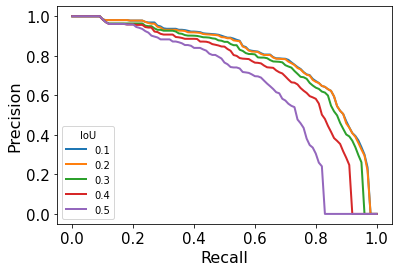

In [35]:
print(mycoco.eval['precision'].shape) #[T,R,K,A,M] parameter dims
# "imgIds": [all] N img ids to use for evaluation 
# "catIds": [all] K cat ids to use for evaluation 
# "iouThrs": [.5:.05:.95] T=10 IoU thresholds for evaluation #this many PR curves to average over
# "recThrs": [0:.01:1] R=101 recall thresholds for evaluation #count precision at these points on curve
# "areaRng": [all,small,medium,large] A=4 area ranges for evaluation 
# "maxDets": [1 10 100] M=3 thresholds on max detections per image
pr = mycoco.eval['precision'][:, #iouthresh
                         :, #recall level
                         0, #catagory
                         0, #area range
                         0] #max detections per image
rc = mycoco.params.recThrs
iou = mycoco.params.iouThrs

for i in range(len(iou)):
    plt.plot(rc,pr[i],label = '{:.2}'.format(iou[i]))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('')
plt.legend(title='IoU')

Number of images: 1176


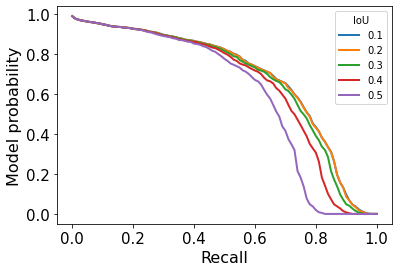

In [36]:

scores = mycoco.eval['scores'][:,:,0,0,0]
#print('Scores:',scores)
print('Number of images:',len(mycoco.params.imgIds))
plt.figure()
for i in range(len(iou)):
    plt.plot(rc,scores[i],label = '{:.2}'.format(iou[i]))
plt.ylabel('Model probability')
plt.xlabel('Recall')
plt.legend(title='IoU')
#print(rc)

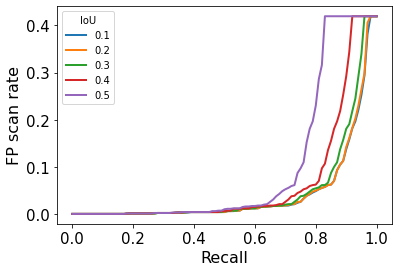

In [37]:
#FP rate, 1 RPD in image = FP
fpr = np.zeros((len(iou),len(rc)))
for i in range(len(iou)):
    for j,s in enumerate(scores[i]):
        ng = 0
        fp = 0
        for el in mycoco.evalImgs:
            if el is None:
                ng=ng+1
            elif len(el['gtIds'])==0:
                ng=ng+1
                if (np.array(el['dtScores']) >s).sum() > 0:
                    fp=fp+1
            else:
                continue
        fpr[i,j] = fp/ng
    plt.plot(rc,fpr[i],label = '{:.2}'.format(iou[i]))
plt.xlabel('Recall')
plt.ylabel('FP scan rate')
plt.legend(title='IoU')              

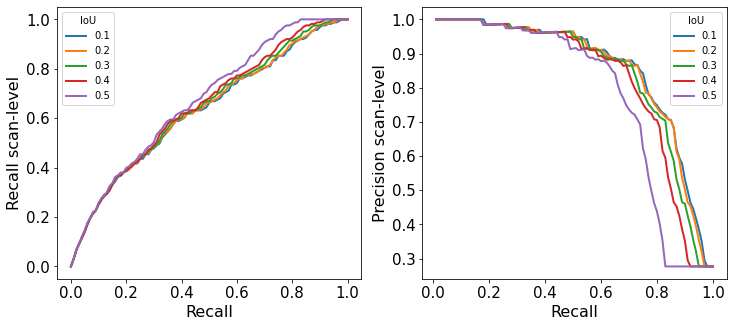

In [18]:
rc_scan = np.zeros((len(iou),len(rc)))#recall (image level)
pr_scan = np.zeros((len(iou),len(rc)))#precision (image level)
fig,ax = plt.subplots(1,2, figsize=[12,5])
for i in range(len(iou)):
    for j,s in enumerate(scores[i]):
        condP = 0 #condition positive
        predP = 0 #predicted positive
        tp = 0 #true positive
        for el in mycoco.evalImgs:
            if el is None: #no condition, no predicted
                continue
            elif len(el['gtIds'])>0: #condition positive
                condP=condP+1
                if (np.array(el['dtScores']) >s).sum() > 0:
                    tp=tp+1
                    predP = predP+1
            elif (np.array(el['dtScores']) >s).sum() > 0: #predicted false positive
                predP = predP+1
            else: #no condition, no predicted (threshold)
                continue
        rc_scan[i,j] = tp/condP
        if predP ==0:
            pr_scan[i,j] = np.nan
        else:
            pr_scan[i,j] = tp/predP
    ax[0].plot(rc,rc_scan[i],label = '{:.2}'.format(iou[i]))
    ax[1].plot(rc,pr_scan[i],label = '{:.2}'.format(iou[i]))
ax[0].set_xlabel('Recall')
ax[0].set_ylabel('Recall scan-level')
ax[0].legend(title='IoU')
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision scan-level')
ax[1].legend(title='IoU') 
#higher IOU requires lower probabilty to get instance-level recall, so scan level-recall (without enforcing iou) is higher with lower probability

In [19]:
data = DatasetCatalog.get('rpd_valid')

In [20]:
#imgId = '101109_OD_oct-002.png'
#imgId = '101109_OD_oct-003.png'
#imgId = '101109_OD_oct-009.png'
#imgId = '101109_OD_oct-007.png'
#imgId = '101109_OD_oct-013.png'
imgId = '101113_OS_oct-039.png'
#imgId = '101113_OS_oct-033.png'
gt_data = next(item for item in data if (item['image_id'] == imgId))
#next(item for item in mycoco.evalImgs if (item['image_id'] == imgId))
#mycoco.evalImgs

(496, 1024, 3)


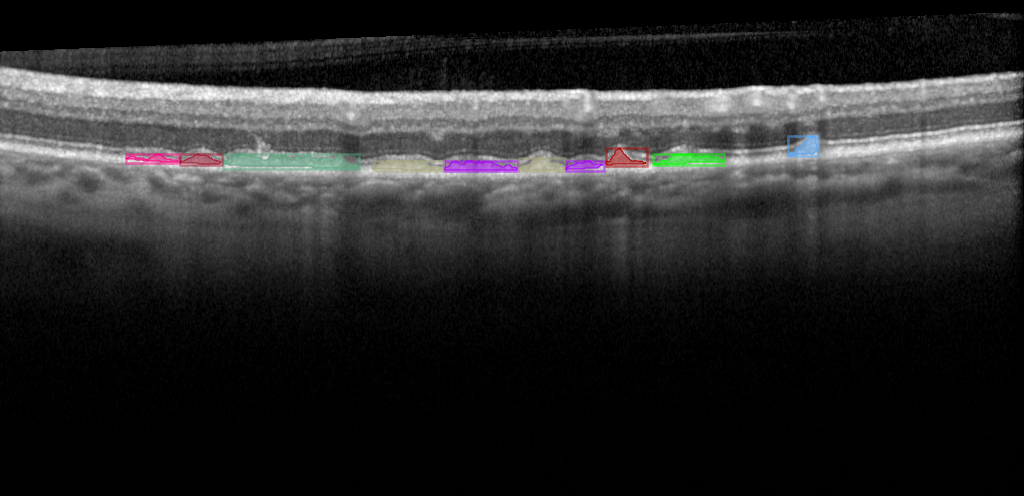

In [21]:
dat = gt_data #gt
im = cv2.imread(dat['file_name']) #input to model
bboxes = [ddict['bbox'] for ddict in dat['annotations']]
BBoxes = detectron2.structures.Boxes(bboxes)
BBoxes = detectron2.structures.BoxMode.convert(BBoxes.tensor,from_mode=1,to_mode=0) #1= XYXY, 2 = XYWH
segs = [ddict['segmentation'] for ddict in dat['annotations']]

v = Visualizer(im, MetadataCatalog.get("rpd_valid"), scale=1.0)
result_image = v.overlay_instances(boxes=BBoxes,masks=segs).get_image()
img = Image.fromarray(result_image)
print(im.shape)
img

In [23]:
from detectron2.engine import DefaultPredictor
pred = DefaultPredictor(cfg)
outputs = pred(im)["instances"].to("cpu")

In [30]:
outputs[outputs.scores>.5]

Instances(num_instances=10, image_height=496, image_width=1024, fields=[pred_boxes: Boxes(tensor([[184.5753, 153.8804, 218.8570, 164.0671],
        [522.7408, 157.6171, 561.6337, 170.2386],
        [604.1277, 148.2665, 635.0090, 166.5660],
        [367.1960, 160.1732, 434.5841, 171.1671],
        [442.9768, 161.3339, 510.1109, 171.6095],
        [660.2083, 150.8181, 699.9202, 163.9155],
        [226.1164, 153.2820, 273.8802, 165.8995],
        [796.2623, 134.9229, 821.4271, 154.4312],
        [570.2296, 161.3829, 599.4161, 168.7843],
        [272.4065, 157.5270, 358.1330, 169.5776]])), scores: tensor([0.9614, 0.9596, 0.9483, 0.9050, 0.8832, 0.8614, 0.6737, 0.6656, 0.6494,
        0.5240]), pred_classes: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, 

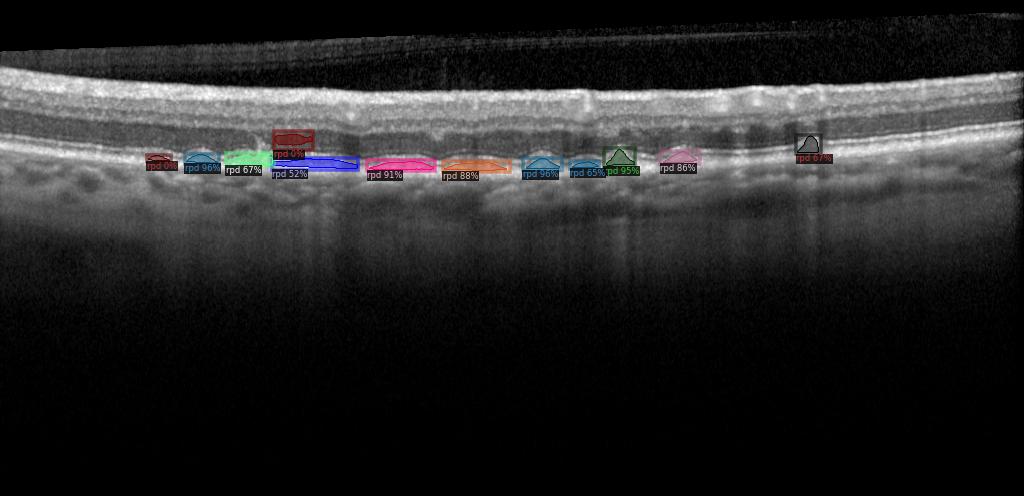

In [24]:
v2 = Visualizer(im, MetadataCatalog.get("rpd_valid"), scale=1.0)
v2._default_font_size = 14
result_model = v2.draw_instance_predictions(outputs).get_image()
img_model = Image.fromarray(result_model)
img_model

In [30]:
with np.printoptions(precision=3,suppress=True):
    print(mycoco.computeIoU(imgId,0))
#mycoco.evalImgs[0]['dtScores']

[[0.    0.    0.    0.    0.    0.    0.74  0.    0.    0.   ]
 [0.    0.    0.    0.777 0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.652 0.   ]
 [0.    0.    0.734 0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.808 0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.434 0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.274 0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.58 ]
 [0.568 0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.471 0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.363 0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]]


In [ ]:

from plain_train_net import EvaluateClass
myeval = EvaluateClass(
    'rpd_valid', cfg.OUTPUT_DIR,iou_thresh = .1,prob_thresh=0.5)
from detectron2.evaluation import inference_on_dataset
results_i = inference_on_dataset(model, myloader, myeval)

In [10]:
p,r = myeval.get_precision_recall()
fpr = myeval.get_fpr()

AttributeError: 'EvaluateClass' object has no attribute 'fpr'

In [8]:
print(p,r)

0.7059773828756059 0.77


In [81]:

def get_all_inputs_outputs():
    with torch.no_grad():
        for data in myloader:
            yield data, model(data)
gen = get_all_inputs_outputs()
inputs, outputs = next(gen)
#from torchviz import make_dot
#list(next(model.named_parameters()))
#make_dot(outputs,params=dict(list(next(model.named_parameters()))).render("model_torchviz", format="png")

SyntaxError: unexpected EOF while parsing (<ipython-input-81-aabb8e2ed1da>, line 9)